Before running this code: ensure that a data folder is created

In [1]:
# Set up AWS
# REPLACE the empty strings with your SOURCE COOPERATIVE credentials
AWS_ACCESS_KEY_ID = "SCY4BH5IZ4MW7ILCG73OZYBV"
AWS_SECRET_ACCESS_KEY = "<HPX3GvZYNB5ymE7qQrpcbnxVQLymfcco5fbmjVRKRqnrDG6ZmzvIGz3zrHRKNyTD"

In [2]:
import numpy as np
import boto3
import os
import dask_geopandas as dg
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
# Create s3 client using boto3 library
s3_client = boto3.client('s3',
                         aws_access_key_id = AWS_ACCESS_KEY_ID, 
                         aws_secret_access_key = AWS_SECRET_ACCESS_KEY,
                         endpoint_url='https://data.source.coop'
                        )

In [50]:
# Start a new Dask cluster
from dask.distributed import Client, LocalCluster
# cluster = LocalCluster()
cluster = LocalCluster(memory_limit='12GB') # I added this, change per system
client = Client(cluster)
print(client.dashboard_link)

/opt/conda/envs/assignment-7/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40915 instead
  warnings.warn(


http://127.0.0.1:40915/status


In [5]:
def download_footprints(country_code):
    """
        This function receives the ISO code for a country and downloads the corresponding geoparquet file.
        
        Parameters
        ----------
        country_code : string
            An string containing the ISO code for the country of interest.
        
        Returns 
        -------
        geoparquet : geoparquet file
            A geoparquet file downloaded to the local directory containing building footprints for the country of interest.
        """
    # Import function to get the available keys from the data
    from utils import get_s3_keys

    # Define bucket name and get the country_iso prefix
    bucket_name = 'vida'
    prefix = "google-microsoft-open-buildings/geoparquet/by_country/country_iso="
    country_prefix = f"{prefix}{country_code}"

    # Get the available keys from the data
    keys = get_s3_keys(bucket_name, country_prefix, s3_client)

    # Download the data for the requested country
    for key in keys:
        local_fname = f"./data/{key.split("/")[-1]}"
        if not os.path.exists(local_fname):
            print(f"File not found locally. Downloading from s3...")
            
            try:
                s3_client.download_file(Bucket = bucket_name,
                                        Key = key,
                                        Filename = f"./data/{key.split("/")[-1]}"
                                       )
                print("Download complete.")
            except:
                print("An error occurred. Download failed")
        else:
            print("File already exists locally. No download needed.")
    

In [6]:
def load_data(country_code, blocksize):
    """
        This function reads the downloaded geoparquet file for a country and loads the building footprints.
        
        Parameters
        ----------
        country_code : string
            An string containing the ISO code for the country of interest.
        blocksize : int
            An integer specifying the block size for Dask partitions. Decreasing can help with memory issues
        
        Returns 
        -------
        bldg_ddf : Dask Geodataframe
            A Dask Geodataframe containing building footprints for the country of interest.
        """
    bldg_ddf = dg.read_parquet(f"./data/{country_code}*.parquet", gather_spatial_partitions=False, blocksize=blocksize)

    return bldg_ddf

In [8]:
# Run the function to download buildidng footprint geoparquet data for Haiti (ISO Code: HTI)
download_footprints("HTI")

File already exists locally. No download needed.


In [7]:
# Run the function to load the building footprints
buildings = load_data("HTI", "128M")

In [8]:
buildings

,boundary_id,bf_source,confidence,area_in_meters,s2_id,country_iso,geohash,geometry,bbox
npartitions=6,,,,,,,,,
,int64,object,float64,float64,int64,object,object,geometry,object
,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


# Plot a histogram of the area of all buildings provided by Microsoft as the source
## Convert the Dask-Geopandas GeoDataFrame to a Pandas series in order to graph
#### This Dask operation took around 3-5 minutes on my machine

In [10]:
area_in_meters_calc = buildings['area_in_meters'].compute()

# Displaying the plot:
### I tried two methods to display the data on a histogram effectively
1. Displaying values less than 1000 meters (mask out the high outliers and max values to view the majority of the data),
   as well as using 100 bins
3. Applying a logarithmic transformation

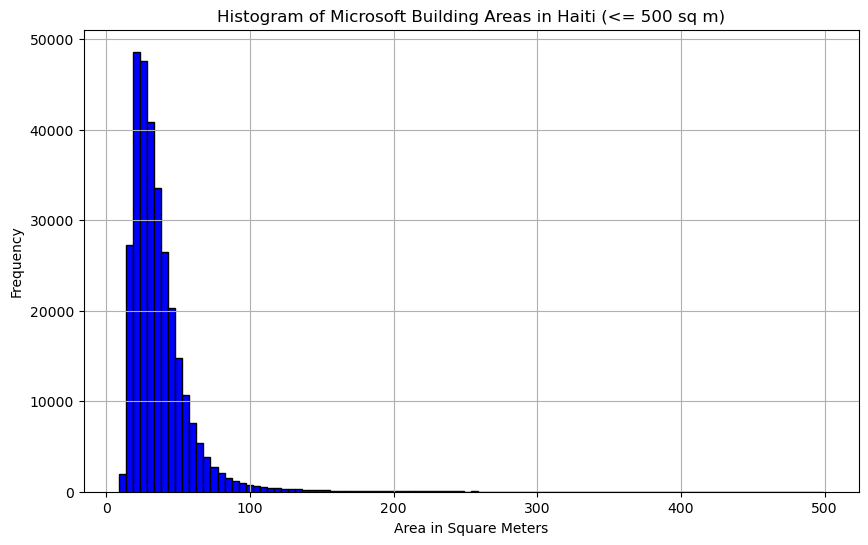

In [11]:
# Displaying values less than 1000 meters
microsoft_buildings = buildings[(buildings['bf_source'] == 'microsoft') & (buildings['area_in_meters'] <= 500)][['area_in_meters']]

# Plot the filtered data
plt.figure(figsize=(10, 6))
plt.hist(microsoft_buildings['area_in_meters'], bins=100, color='blue', edgecolor='black')
plt.title('Histogram of Microsoft Building Areas in Haiti (<= 500 sq m)')
plt.xlabel('Area in Square Meters')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

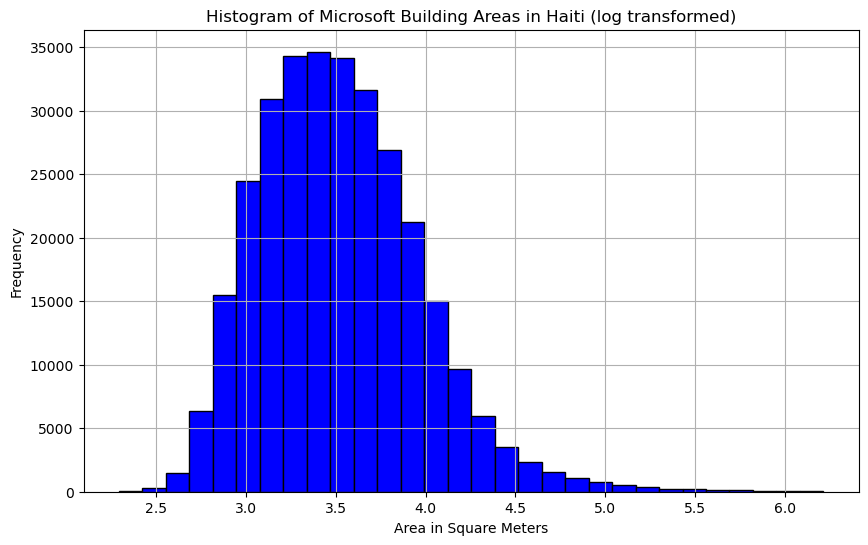

In [12]:
# Plot histogram
microsoft_buildings['log_area'] = np.log(microsoft_buildings['area_in_meters'] + 1)

plt.figure(figsize=(10, 6))
plt.hist(microsoft_buildings['log_area'], bins=30, color='blue', edgecolor='black')
plt.title('Histogram of Microsoft Building Areas in Haiti (log transformed)')
plt.xlabel('Area in Square Meters')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Counting the number of building footprints that intersect with each other

In [36]:
print(type(buildings))

<class 'dask_geopandas.expr.GeoDataFrame'>


In [37]:
from dask_geopandas import sjoin
intersections = sjoin(buildings, buildings, how='inner', predicate='intersects')

In [38]:
# Filter out self-intersections using .loc
intersections = intersections.loc[intersections.index != intersections["index_right"]]

In [39]:
# Count the number of intersections for each building
intersection_counts = intersections.groupby(intersections.index).size()

In [40]:
intersections_filtered = intersections.loc[intersections.index != intersections["index_right"]]

In [41]:
# Convert intersection_counts from dask series into a  pandas geoDataFrame
intersection_counts_df = intersection_counts.to_frame(name='intersection_count')

In [42]:
# Merge the fields of 'bf_source_left' and 'bf_source_right'
merged_result = intersections_filtered[['bf_source_left', 'bf_source_right']].merge(
    intersection_counts_df, left_index=True, right_index=True, how='left'
)

In [43]:
# Persist in memory so we don't have to calculate again in Dask
merged_result = merged_result.persist()

In [44]:
# Compute result
merged_result_computed = merged_result.compute()

In [45]:
print(merged_result_computed)

       bf_source_left bf_source_right  intersection_count
141            google          google                   2
295            google          google                   4
295            google          google                   4
317            google          google                   7
317            google          google                   7
...               ...             ...                 ...
353737         google          google                   4
354115         google          google                   3
354209         google          google                   5
354237         google          google                   2
354616         google          google                   4

[1988984 rows x 3 columns]


In [46]:
# I divided the result by two since each building index records an intersection with the other (thus it records twice)
total_intersections2 =  merged_result_computed['intersection_count'].sum() // 2
print(f"Total number of intersections: {total_intersections2}")

Total number of intersections: 4179795


# Counting the number of Google footprints that intersect with other Google footprints

In [47]:
# Google and Google Intersections
# Filter the rows where both bf_source_left and bf_source_right are 'google'
google_intersections = merged_result_computed[
    (merged_result_computed['bf_source_left'] == 'google') & 
    (merged_result_computed['bf_source_right'] == 'google')
]

# Sum the intersection counts and divide by 2
total_google_intersections = google_intersections['intersection_count'].sum() // 2

print(f"Total number of Google-to-Google intersections: {total_google_intersections}")


Total number of Google-to-Google intersections: 4178098


# Counting the number of Microsoft footprints that intersect with other Microsoft footprints

In [48]:
# Microsoft and Microsoft Intersections
# Filter the rows where both bf_source_left and bf_source_right are 'microsoft'
microsoft_intersections = merged_result_computed[
    (merged_result_computed['bf_source_left'] == 'microsoft') & 
    (merged_result_computed['bf_source_right'] == 'microsoft')
]

# Sum the intersection counts and divide by 2
total_microsoft_intersections = microsoft_intersections['intersection_count'].sum() // 2

print(f"Total number of Microsoft-to-Microsoft intersections: {total_microsoft_intersections}")

Total number of Microsoft-to-Microsoft intersections: 1697


# Counting the number of Google footprints that intersect with Microsoft footprints

In [49]:
# Google and Microsoft Intersections
# Filter the rows where both bf_source_left is 'microsoft' and bf_source_right is g'oogle'
# Need to add both cases, left or right, to catch any intersections
microsoft_google_intersections = merged_result_computed[
    ((merged_result_computed['bf_source_left'] == 'google') & (merged_result_computed['bf_source_right'] == 'microsoft')) |
    ((merged_result_computed['bf_source_left'] == 'microsoft') & (merged_result_computed['bf_source_right'] == 'google'))
]

# Sum the intersection counts and divide by 2
total_microsoft_google_intersections = microsoft_google_intersections['intersection_count'].sum() // 2

print(f"Total number of Google-to-Microsoft intersections: {total_microsoft_google_intersections}")

Total number of Google-to-Microsoft intersections: 0
